In [2]:
!pip install editdistance
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q
!pip install editdistance

import locale
import pandas as pd
import numpy as np
import re
import sys
import typing as tp
import unicodedata
import gc
import random
import torch
import sacrebleu
import editdistance
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig, get_constant_schedule_with_warmup
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from sacremoses import MosesPunctNormalizer

pd.options.display.max_colwidth = 100


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 43.9 MB/s eta 0:00:00


In [3]:
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [5]:
trans_df = pd.read_csv('tyv_rus_parallel.csv')
trans_df = trans_df.sample(frac=1).reset_index(drop=True)
trans_df['split'] = 'train'

test_indices = np.random.choice(trans_df.index, size=5000, replace=False)
dev_indices = np.random.choice(trans_df.drop(test_indices).index, size=5000, replace=False)

trans_df.loc[test_indices, 'split'] = 'test'
trans_df.loc[dev_indices, 'split'] = 'dev'

print(trans_df.shape)
print(trans_df.columns)

(118191, 3)
Index(['ru', 'tyv', 'split'], dtype='object')


In [6]:
trans_df.sample(10)

,ru,tyv,split
12537,"А я плакал, — пожаловался Самат.","А мен ыглап турдум – деп, Самат хомудады.",train
102850,слабость воли,күзел-соруктуң кошкаа,train
21439,стиль плавания,эштириниң аргазы,train
54853,Горищница,Горищница,train
33346,сговориться,сүлчээлежир,train
103166,растрата,самчыгдал,train
90490,Кисела-Вода,Кисела-Вода,train
68707,"Десять лет назад их было 790, сейчас 395.","Он чыл бурунгаар ындыг чурум үрээшкиннериниң саны 790 чедип турган болза, ам ооң саны 395 чедир ...",train
16830,левый бок,солагай талакы быгын,train
8719,купить в кредит,чээп садып алыр,train


In [10]:
trans_df = trans_df[trans_df.ru.notna()]
trans_df.isnull().sum()

ru       0
tyv      0
split    0
dtype: int64

In [11]:
trans_df.split.value_counts()

split
train    108183
test       5000
dev        4999
Name: count, dtype: int64

In [12]:
df_train = trans_df[trans_df.split=='train'].copy()
df_dev = trans_df[trans_df.split=='dev'].copy()
df_test = trans_df[trans_df.split=='test'].copy()

In [13]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

In [14]:
def word_tokenize(text):
    return re.findall('(\w+|[^\w\s])', text)

In [15]:
smpl = df_train.sample(10000, random_state=1)

smpl['rus_toks'] = smpl.ru.apply(tokenizer.tokenize)
smpl['tyv_toks'] = smpl.tyv.apply(tokenizer.tokenize)

smpl['rus_words'] = smpl.ru.apply(word_tokenize)
smpl['tyv_words'] = smpl.tyv.apply(word_tokenize)

In [16]:
smpl.sample(5)[['tyv', 'tyv_words', 'tyv_toks', 'ru', 'rus_words', 'rus_toks']]

,tyv,tyv_words,tyv_toks,ru,rus_words,rus_toks
109411,Макоку,[Макоку],"[▁Ма, ко, ку]",Макоку,[Макоку],"[▁Ма, ко, ку]"
5939,удаажырааны,[удаажырааны],"[▁удаа, жы, раа, ны]",давность,[давность],"[▁давно, сть]"
51661,кара-бажыңга кирер,"[кара, -, бажыңга, кирер]","[▁кара, -, ба, жы, ң, га, ▁ки, рер]",сесть в тюрьму,"[сесть, в, тюрьму]","[▁се, сть, ▁в, ▁тю, рь, му]"
98277,хүн бүрүнүң,"[хүн, бүрүнүң]","[▁хүн, ▁бүр, үн, үң]",обиходный,[обиходный],"[▁оби, ход, ный]"
112031,чүн,[чүн],"[▁ч, үн]",спинной мозг,"[спинной, мозг]","[▁спи, н, ной, ▁моз, г]"


In [17]:
stats = smpl[['rus_toks', 'tyv_toks', 'rus_words', 'tyv_words']].applymap(len).describe()
stats

,rus_toks,tyv_toks,rus_words,tyv_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,8.843000,12.255900,4.833600,5.382500
std,10.645238,15.890521,6.508544,7.216564
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,4.000000,1.000000,1.000000
50%,5.000000,6.000000,2.000000,3.000000
75%,9.000000,13.000000,5.000000,6.000000
max,113.000000,185.000000,73.000000,76.000000


In [18]:
print(stats.rus_toks['mean'] / stats.rus_words['mean'])
print(stats.tyv_toks['mean'] / stats.tyv_words['mean'])

1.8294852697782193
2.2769902461681375


In [19]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


In [20]:
texts_with_unk = [text for text in tqdm(trans_df.tyv) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/118182 [00:00<?, ?it/s]

3646


In [21]:
import random
s = random.sample(texts_with_unk, 5)
s

['Үр эвес чурттаарывыс арткан болганда, сөөлгү хүннеривисти моон чөөн чүкче турар черлер дилээринге бараалгадыылыңар!» – деп алгырган.',
 '"""Шак бо черге кым чыргап чурттаарын шиитпирлээр үелер келген-дир"" – деп, олар чугаалажырлар."',
 'Мен чоруптайн, Баке – деп, ол харыылады.',
 'Анна Маадыровна Анай-оол – 42 чыл дургузунда Бай-Тал ортумак школазында эге класстар башкызы болуп ажылдап чоруур.',
 'Асель! – деп, ол алгырды.']

In [22]:
mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [23]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/3646 [00:00<?, ?it/s]

18


In [24]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

256204
['zul_Latn', '<mask>']


In [25]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [26]:
fix_tokenizer(tokenizer)

In [27]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'tyv_Cyrl', '<mask>']
[256202, 256203, 256204]


In [28]:
added_token_id = tokenizer.convert_tokens_to_ids('tyv_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [60]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(256205, 1024)

In [61]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

In [62]:
def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [63]:
model.cuda();

In [64]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [65]:
batch_size = 32 
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [66]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [67]:
LANGS = [('ru', 'rus_Cyrl'), ('tyv', 'tyv_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))
# (['чеди'], ['семь'], 'tyv_Cyrl', 'rus_Cyrl')

(['я прочитал бы эту книгу, если бы у меня было время'], ['меңээ үе-шак турган болза, бо номну номчуур ийик мен'], 'rus_Cyrl', 'tyv_Cyrl')


In [69]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

  0%|          | 0/57000 [00:00<?, ?it/s]

0 3.4980714321136475
1000 3.308365369915962
2000 2.309062501549721
3000 1.9522576620578767
4000 1.7630822297334672
5000 1.632921978533268
6000 1.5221224780678748
7000 1.449269755423069
8000 1.369331463456154
9000 1.312260545730591
10000 1.2603425319194794
11000 1.2054766879081726
12000 1.1625192789435386
13000 1.1192971930503846
14000 1.0901859654188155
15000 1.0644576606750489
16000 1.0254192346930504
17000 0.9936578414440155
18000 0.9651414786577225
19000 0.9375172211527825
20000 0.8992606436610222
21000 0.8780954212248325
22000 0.8639922308325767
23000 0.8374491085708141
24000 0.8154546610713005
25000 0.7915017855763435
26000 0.7645463365912437
27000 0.7422154033482075
28000 0.7294906226098538
29000 0.7014525937736035
30000 0.7041781523227691
31000 0.680812860161066
32000 0.6658166252523661
33000 0.6435427843332291
34000 0.629445339024067
35000 0.6137348725199699
36000 0.5996274981498718
37000 0.5744809785187245
38000 0.5717721190452576
39000 0.5591350983232259
40000 0.5436932438462

In [ ]:
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

('/MyDrive/nllb-rus-tyv-v1/tokenizer_config.json',
 '/MyDrive/nllb-rus-tyv-v1/special_tokens_map.json',
 '/MyDrive/nllb-rus-tyv-v1/sentencepiece.bpe.model',
 '/MyDrive/nllb-rus-tyv-v1/added_tokens.json')

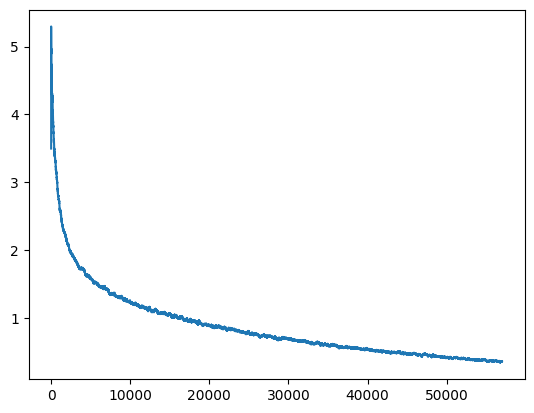

In [70]:
pd.Series(losses).ewm(100).mean().plot();

In [71]:
def translate(text, src_lang='rus_Cyrl', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [ ]:
mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))

        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [ ]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [83]:
df_dev['rus_translated'] = [translate(t, 'tyv_Cyrl', 'rus_Cyrl')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv_translated'] = [translate(t, 'rus_Cyrl', 'tyv_Cyrl')[0] for t in tqdm(df_dev.ru)]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

In [84]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [85]:
xx, yy = ['течёт холод'], ['несёт холодом']
print(bleu_calc.corpus_score(xx, [yy]))
print(chrf_calc.corpus_score(xx, [yy]))
print(chrf_calc.corpus_score(yy, [xx]))

BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 2 ref_len = 2)
chrF2++ = 36.75
chrF2++ = 42.30


In [86]:
print(bleu_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(chrf_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(bleu_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))

BLEU = 25.52 52.4/31.3/20.0/13.4 (BP = 0.991 ratio = 0.991 hyp_len = 22993 ref_len = 23207)
chrF2++ = 49.35
BLEU = 25.68 53.4/31.4/20.0/13.2 (BP = 0.996 ratio = 0.996 hyp_len = 23085 ref_len = 23188)
chrF2++ = 52.85


In [87]:
print((df_dev.ru == df_dev.rus_translated).mean())
print((df_dev.tyv == df_dev.tyv_translated).mean())

0.27525505101020203
0.26685337067413484


In [88]:
def ed_similarity(text1, text2):
    return max(0, 1 - editdistance.eval(text1, text2) / min(len(text1), len(text2)))

print(ed_similarity('кот', 'собака'))
print(ed_similarity('кот', 'кит'))

0
0.6666666666666667


# Publishing the model to HF

In [89]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig

In [ ]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [90]:
upload_repo = "Nacoor/mbart-v1"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Nacoor/mbart-v1/commit/85fc294be571b6794077b790332f7cb3adc970bd', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='85fc294be571b6794077b790332f7cb3adc970bd', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', '<mask>', 'tyv_Cyrl']
[256202, 256204, 256203]


Testing that it works

In [91]:
MODEL_URL = 'Nacoor/mbart-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL)
tokenizer = NllbTokenizer.from_pretrained(MODEL_URL, force_download=True)
fix_tokenizer(tokenizer)

config.json:   0%|          | 0.00/896 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.56k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [92]:
def translate(
    text,
    model,
    tokenizer,
    src_lang='rus_Cyrl',
    tgt_lang='tyv_Cyrl',
    max_length='auto',
    num_beams=4,
    no_repeat_ngram_size=4,
    n_out=None,
    **kwargs
):
    tokenizer.src_lang = src_lang
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if max_length == 'auto':
        max_length = int(32 + 2.0 * encoded.input_ids.shape[1])
    model.eval()
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
        max_length=max_length,
        num_beams=num_beams,
        no_repeat_ngram_size=no_repeat_ngram_size,
        num_return_sequences=n_out or 1,
        **kwargs
    )
    out = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    if isinstance(text, str) and n_out is None:
        return out[0]
    return out

In [95]:
translate("когда ты приехал домой?", model=model, tokenizer=tokenizer)

'сен кажан чанып келдиң?'

In [ ]:
translate("красная птица", model=model, tokenizer=tokenizer, tgt_lang='eng_Latn')

': кызыл куш'